<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/mobilenetv2_2.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip dataset.zip

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/dataset_3'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
train_dir = '/content/dataset_3/train'
test_dir = '/content/dataset_3/train'
val_dir = '/content/dataset_3/validation'

In [4]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
# Create a list with the filepaths for training and testing
train_dir = Path('../content/dataset_3/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('../content/dataset_3/train')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [7]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)

    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Number of pictures: 2780

Number of different labels: 36

Labels: ['spinach' 'beetroot' 'lettuce' 'eggplant' 'potato' 'bell pepper'
 'pomegranate' 'capsicum' 'ginger' 'pineapple' 'corn' 'mango' 'apple'
 'paprika' 'peas' 'carrot' 'turnip' 'sweetcorn' 'garlic' 'watermelon'
 'grapes' 'cabbage' 'lemon' 'soy beans' 'cucumber' 'tomato'
 'chilli pepper' 'pear' 'onion' 'orange' 'sweetpotato' 'kiwi'
 'cauliflower' 'raddish' 'jalepeno' 'banana']


Filepath     Label
0   ../content/dataset_3/train/spinach/Image_65.jpg   spinach
1   ../content/dataset_3/train/spinach/Image_36.jpg   spinach
2  ../content/dataset_3/train/beetroot/Image_38.jpg  beetroot
3   ../content/dataset_3/train/lettuce/Image_26.jpg   lettuce
4  ../content/dataset_3/train/eggplant/Image_69.jpg  eggplant

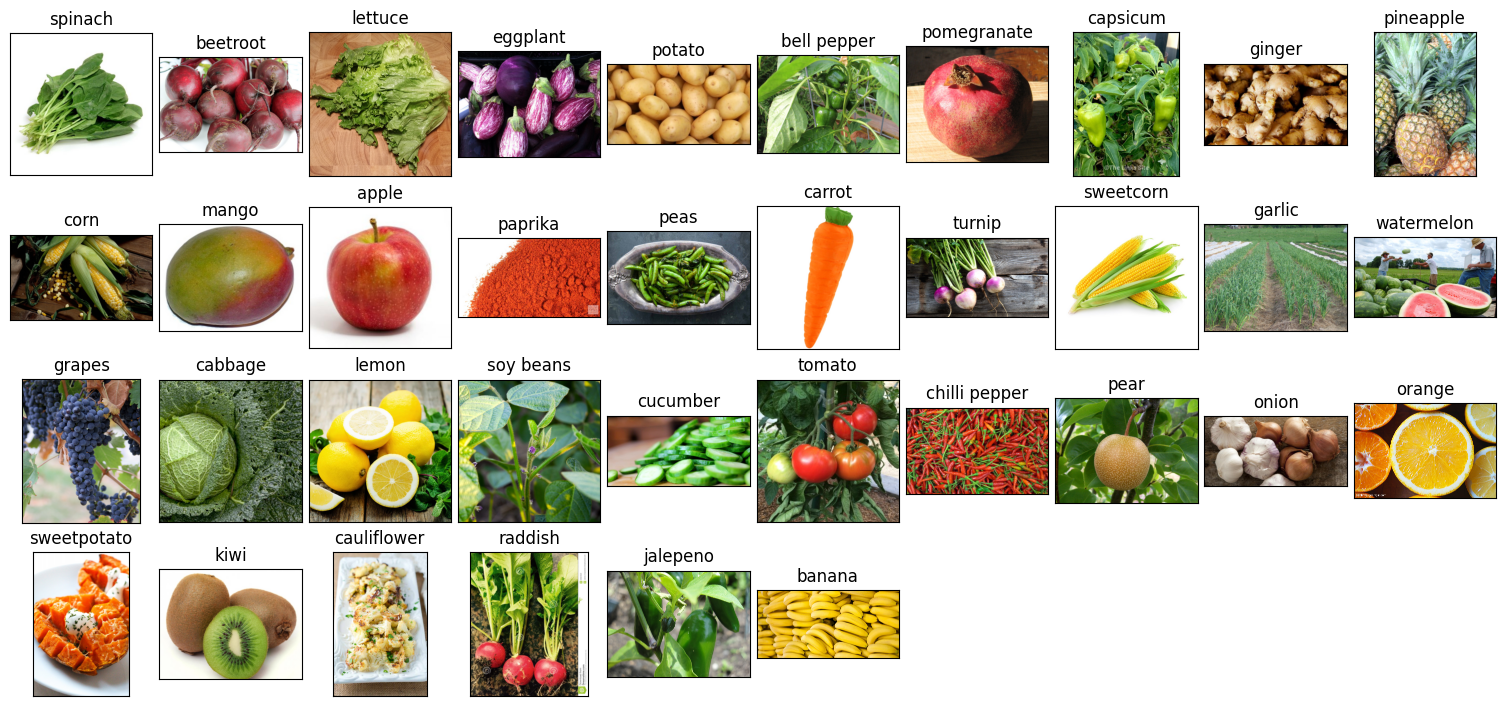

In [10]:
# Create a DataFrame with one Label of each category
df_unique = train_df.drop_duplicates(subset=["Label"]).reset_index(drop=True)

# Display some pictures of the dataset
n_rows = 4
n_cols = 10
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(df_unique):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off empty subplots

plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2224 validated image filenames belonging to 36 classes.
Found 556 validated image filenames belonging to 36 classes.
Found 2780 validated image filenames belonging to 36 classes.


In [12]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [68]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30
)

Epoch 1/30
70/70 [==============================] - 178s 2s/step - loss: 1.9152 - accuracy: 0.4991 - val_loss: 1.0884 - val_accuracy: 0.6565
Epoch 2/30
70/70 [==============================] - 169s 2s/step - loss: 0.6121 - accuracy: 0.8098 - val_loss: 0.8046 - val_accuracy: 0.7554
Epoch 3/30
70/70 [==============================] - 172s 2s/step - loss: 0.3519 - accuracy: 0.8885 - val_loss: 0.8390 - val_accuracy: 0.7626
Epoch 4/30
70/70 [==============================] - 155s 2s/step - loss: 0.2330 - accuracy: 0.9303 - val_loss: 0.7874 - val_accuracy: 0.7698
Epoch 5/30
70/70 [==============================] - 165s 2s/step - loss: 0.1609 - accuracy: 0.9523 - val_loss: 0.7346 - val_accuracy: 0.7860
Epoch 6/30
70/70 [==============================] - 166s 2s/step - loss: 0.0924 - accuracy: 0.9757 - val_loss: 0.7442 - val_accuracy: 0.7824
Epoch 7/30
70/70 [==============================] - 165s 2s/step - loss: 0.0823 - accuracy: 0.9775 - val_loss: 0.8141 - val_accuracy: 0.7932
Epoch 8/30
70

In [69]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

87/87 [==============================] - 170s 2s/step
The first 5 predictions: ['capsicum', 'peas', 'raddish', 'eggplant', 'garlic']


In [70]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 95.25%


In [71]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

               precision    recall  f1-score   support

        apple       0.96      0.95      0.96        58
       banana       0.98      0.97      0.98        62
     beetroot       0.97      0.99      0.98        84
  bell pepper       0.92      0.86      0.89        78
      cabbage       0.99      1.00      0.99        84
     capsicum       0.89      0.89      0.89        80
       carrot       0.99      0.95      0.97        73
  cauliflower       0.99      0.99      0.99        71
chilli pepper       0.94      0.89      0.92        76
         corn       0.80      0.95      0.87        84
     cucumber       1.00      0.95      0.97        78
     eggplant       0.96      0.97      0.97        77
       garlic       0.95      0.98      0.96        83
       ginger       0.98      0.98      0.98        64
       grapes       1.00      0.93      0.96        85
     jalepeno       0.89      0.95      0.92        79
         kiwi       0.99      0.99      0.99        82
        l

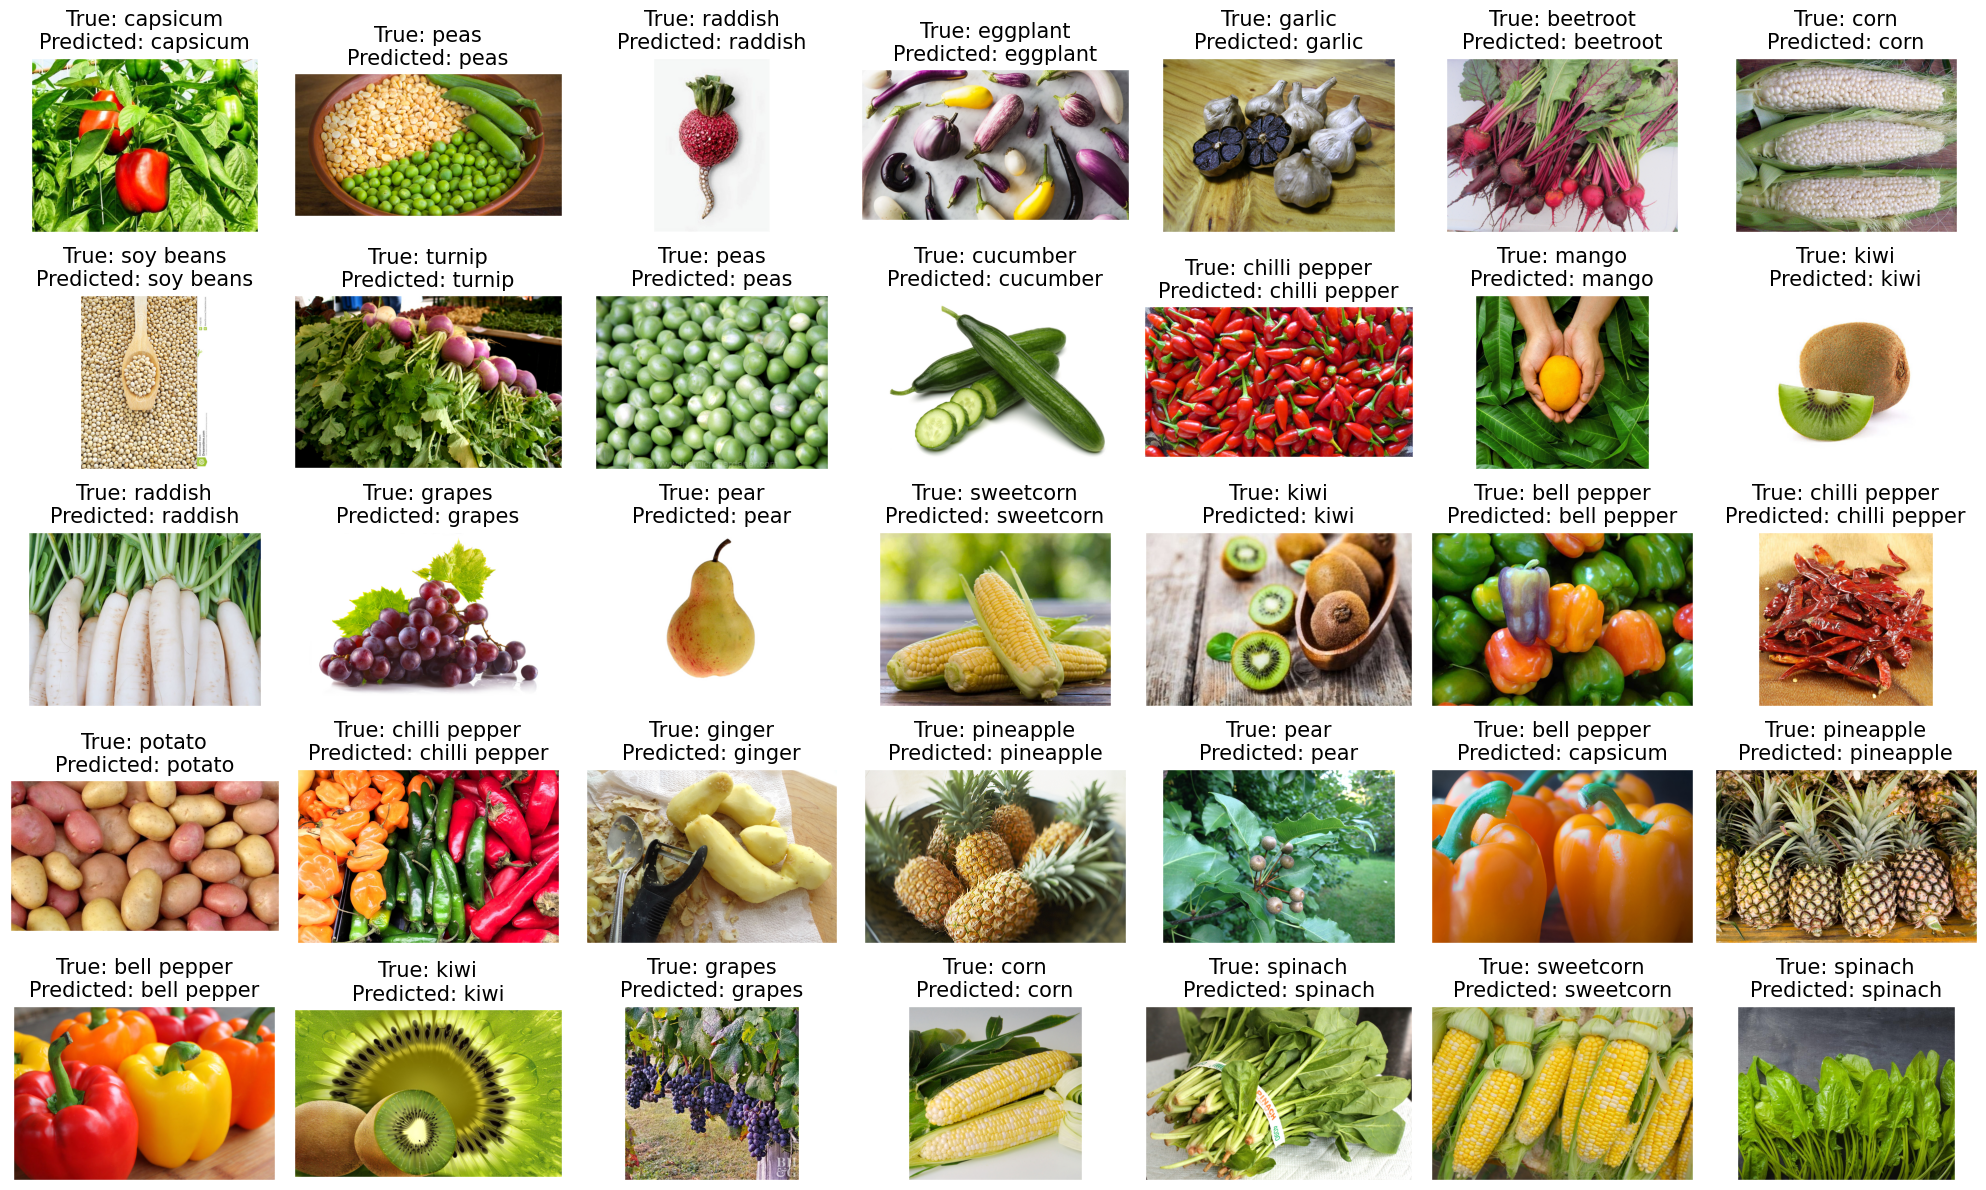

In [72]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [73]:
def plot_graghs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

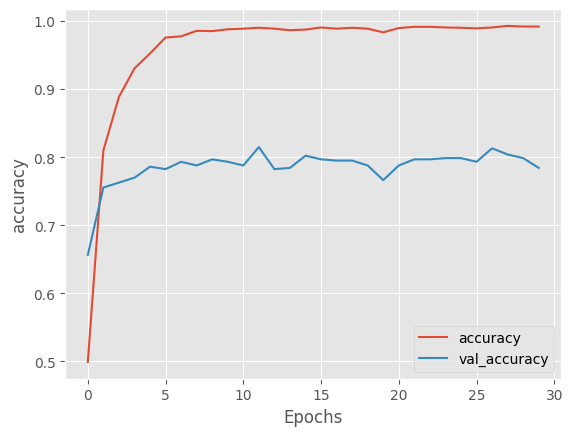

In [74]:
plot_graghs(history, 'accuracy')

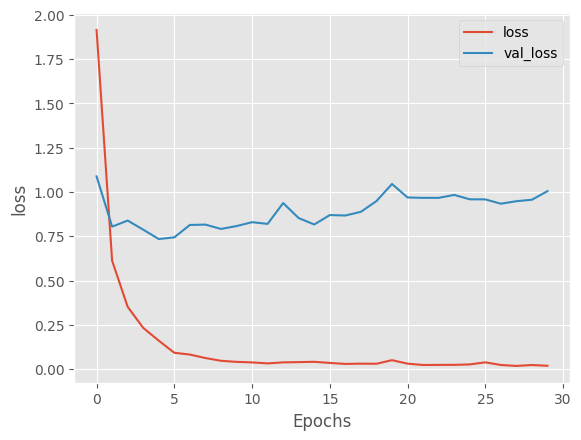

In [75]:
plot_graghs(history, 'loss')

Text(0.5, 0, 'N.of Epochs')

<Figure size 640x480 with 0 Axes>

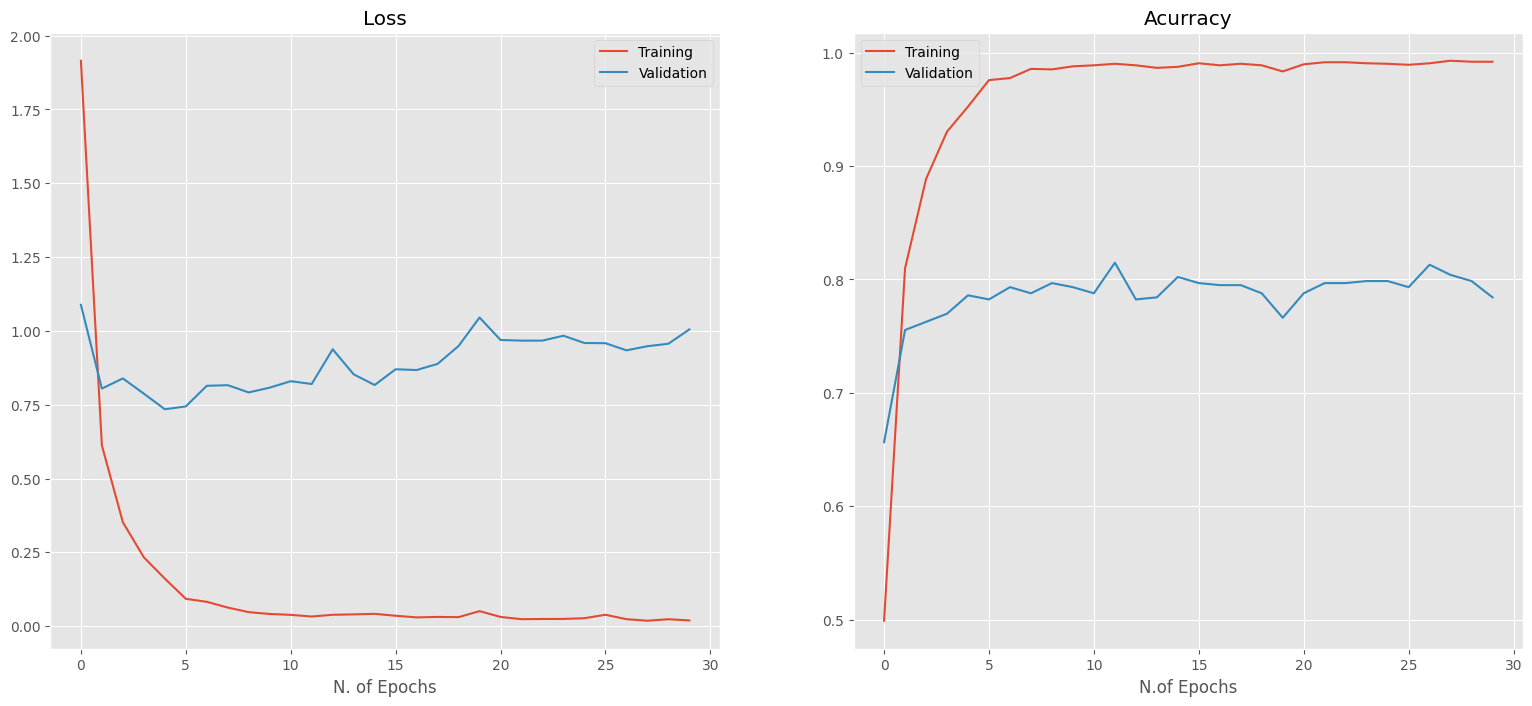

In [76]:
# Plot training loss vs validation loss
plt.style.use('ggplot')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('N. of Epochs')
## plot training accuracy vs validation accuracy
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Acurracy')
ax2.set_xlabel('N.of Epochs')

In [77]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
pred

87/87 [==============================] - 168s 2s/step


array([ 5, 24, 28, ..., 26,  9, 23])

In [78]:
labels = (train_images.class_indices)
labels

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [79]:
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.25%


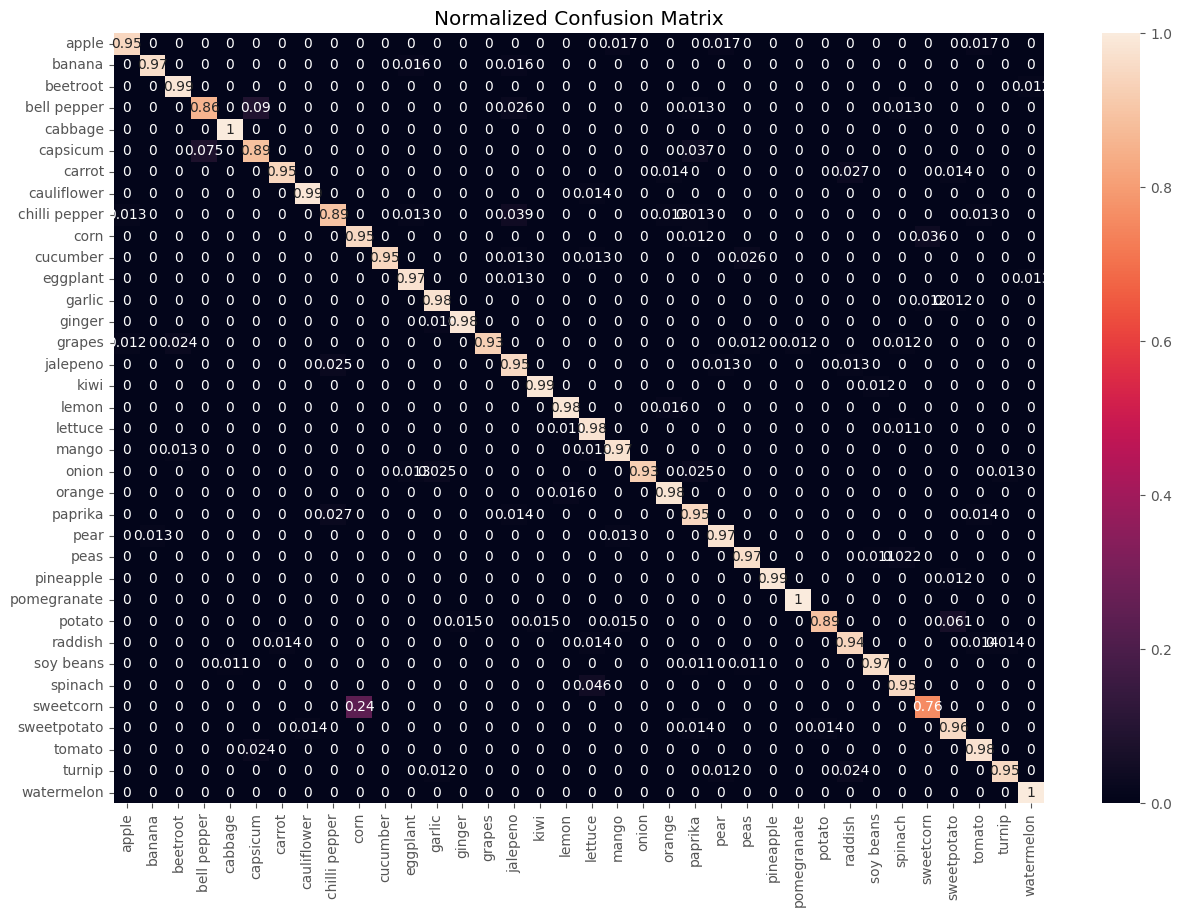

In [80]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()

In [81]:
# Salvar o modelo
model.save('/content/MobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [95]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Carregar o modelo treinado
model = tf.keras.models.load_model('/content/MobileNet.h5')

# Preparar o conjunto de dados de teste
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/dataset_3/test',
    target_size=(224, 224),  # Tamanho das imagens de entrada esperado pelo modelo
    batch_size=32,
    class_mode='categorical'  # Modo de classificação (pode variar dependendo do seu modelo)
)

# Fazer previsões
predictions = model.predict(test_generator)

# Agora você pode processar as previsões, calcular métricas de desempenho, etc.

Found 359 images belonging to 36 classes.
12/12 [==============================] - 27s 2s/step


In [147]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

# Carregue o modelo MobileNetV2 treinado
model = MobileNetV2(weights='imagenet')

# Carregue e pré-processe a imagem de entrada
img_path = '/content/OIP3.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Ajuste o tamanho da imagem de acordo com o MobileNetV2
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Faça a inferência
predictions = model.predict(x)

# Decodifique as previsões
decoded_predictions = decode_predictions(predictions, top=5)[0]

# Imprima as previsões
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i + 1}: {label} ({score:.2f})")


1/1 [==============================] - 2s 2s/step
1: buckeye (0.56)
2: pomegranate (0.07)
3: grocery_store (0.06)
4: Granny_Smith (0.02)
5: banana (0.01)
